In [1]:
!pip install git+https://github.com/brianbt/btorch

  Cloning https://github.com/brianbt/btorch to /tmp/pip-req-build-jzjo5tcd
  Running command git clone --filter=blob:none --quiet https://github.com/brianbt/btorch /tmp/pip-req-build-jzjo5tcd
  Resolved https://github.com/brianbt/btorch to commit 6ca95b384e3b8e3208f3441478ea112aa6545a84
  Preparing metadata (setup.py) ... done
  Created wheel for btorch: filename=btorch-0.0.1-py3-none-any.whl size=52680 sha256=2c24c39242516e5626e3eb7c5f143a11366796e5cd4e2566f1a0be3938ab7300
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qn07hhr/wheels/fa/ef/1e/1248ce8683f1b6fd8e6552260da8c1dcfbb352d899fef03d72
Successfully built btorch


In [2]:
import torch
import btorch
from btorch import nn
import btorch.nn.functional as F
from btorch.vision.utils import UnNormalize
from torchvision import transforms, datasets
from tqdm import tqdm
from matplotlib import pyplot as plt

# Load Dataset, CIFAR10

In [3]:
# Load CIFAR10 dataset, do augmentation on the trainset
transform_train = transforms.Compose([
  transforms.Resize(64),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])
transform_test = transforms.Compose([
  transforms.Resize(64),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])
trainset = datasets.CIFAR10('./cifar10',train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10('./cifar10',train=False, download=True, transform=transform_test)

# # Only select the `dog` class
# train_idx = torch.tensor(trainset.targets,dtype=torch.long) == 7
# test_idx = torch.tensor(testset.targets,dtype=torch.long) == 7
# trainset.targets = torch.tensor(trainset.targets,dtype=torch.long)[train_idx]
# trainset.data = trainset.data[train_idx]
# testset.targets = torch.tensor(testset.targets,dtype=torch.long)[test_idx]
# testset.data = testset.data[test_idx]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


# Create GAN Model

## Generator and Discriminator

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self,x):
        return self.main(x)
    def sample(self, batch_size = 1):
        noise = torch.randn((batch_size, self.latent_dim, 1, 1), device=self.device)
        return self.forward(noise)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.main(x)
        

## Lets test the Generator and Discriminator output

In [9]:
g = Generator(100)
print(g.summary(input_size = (16,100,1,1)))
d = Discriminator()
print(d.summary(input_size=(16,3,64,64)))
print(d(g.sample(1)).shape)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [16, 3, 64, 64]           --
├─Sequential: 1-1                        [16, 3, 64, 64]           --
│    └─ConvTranspose2d: 2-1              [16, 512, 4, 4]           819,200
│    └─BatchNorm2d: 2-2                  [16, 512, 4, 4]           1,024
│    └─ReLU: 2-3                         [16, 512, 4, 4]           --
│    └─ConvTranspose2d: 2-4              [16, 256, 8, 8]           2,097,152
│    └─BatchNorm2d: 2-5                  [16, 256, 8, 8]           512
│    └─ReLU: 2-6                         [16, 256, 8, 8]           --
│    └─ConvTranspose2d: 2-7              [16, 128, 16, 16]         524,288
│    └─BatchNorm2d: 2-8                  [16, 128, 16, 16]         256
│    └─ReLU: 2-9                         [16, 128, 16, 16]         --
│    └─ConvTranspose2d: 2-10             [16, 64, 32, 32]          131,072
│    └─BatchNorm2d: 2-11                 [16, 64, 32, 32] 

## Create GAN Module

In [10]:
class GAN(nn.Module):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.g=Generator(latent_dim)
        self.d=Discriminator()
    def forward(self,x):
        return self.d(x)
    def sample(self, batch_size):
        return self.g.sample(batch_size)
    
    @classmethod
    def train_epoch(cls, net, criterion, trainloader, optimizer, epoch_idx, device='cuda', config=None,**kwargs):
        """This is the very basic training function for one epoch. Override this function when necessary
            
        Returns:
            (float): train_loss
        """
        net.g.train()
        net.d.train()
        G_loss = 0
        D_loss = 0
        G_curr_loss = 0 
        D_curr_loss = torch.nan
        pbar = tqdm(enumerate(trainloader), total=len(trainloader), disable=(kwargs.get("verbose", 1)==0))
        for batch_idx, (inputs, _) in pbar:
            # Trian G ###############################
            optimizer['G'].zero_grad()
            fake_inputs = net.sample(inputs.shape[0])
            fool_labels = torch.ones(inputs.shape[0], device=net.device)
            fool_predicted = net.d(fake_inputs).view(-1)
            G_fool_loss = criterion(fool_predicted, fool_labels)
            G_fool_loss.backward()
            
            optimizer['G'].step()
            G_curr_loss = G_fool_loss.item()
            G_loss += G_curr_loss
            
            # Trian D ###############################
            if epoch_idx >= 0: # train Discriminator less
                optimizer['D'].zero_grad()
                ## Train with real data
                inputs = inputs.to(device)
                real_labels = torch.ones(inputs.shape[0], device=net.device)
                real_predicted = net.d(inputs).view(-1)
                D_real_loss = criterion(real_predicted, real_labels)

                ## Train with fake data
                fake_labels = torch.zeros(inputs.shape[0], device=net.device)
                fake_predicted = net.d(fake_inputs.detach()).view(-1)
                D_fake_loss = criterion(fake_predicted, fake_labels)

                D_curr_lossB = D_real_loss+D_fake_loss
                D_curr_lossB.backward()
                optimizer['D'].step()
                
                D_curr_loss = D_curr_lossB.item()
                D_loss = D_loss + D_curr_loss
            
            pbar.set_description(
                f"epoch {epoch_idx+1} iter {batch_idx}: D loss {D_curr_loss:.5f}, G loss {G_curr_loss:.5f}.")
        return {'D_loss': D_loss/(batch_idx+1), 'G_loss': G_loss/(batch_idx+1)}

    @classmethod
    def on_train_epoch_begin(cls, net, criterion, optimizer, trainloader, testloader=None, epoch_idx=0, lr_scheduler=None, config=None,**kwargs):
      config['evol'].append(net.g(config['evol_seed']))

    @classmethod
    def test_epoch(cls, net, criterion, testloader, epoch_idx=0, scoring=None, device='cuda', config=None,**kwargs):
        """This is the very basic evaluating function for one epoch. Override this function when necessary
            
        Returns:
            (float): eval_loss
        """
        net.g.eval()
        net.d.eval()
        G_loss = 0
        D_loss = 0
        with torch.inference_mode():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                # Test G ###############################
                fake_inputs = net.sample(inputs.shape[0])
                fool_labels = torch.ones(inputs.shape[0], device=net.device)
                fool_predicted = net.d(fake_inputs).view(-1)
                G_fool_loss = criterion(fool_predicted, fool_labels)
                G_loss += G_fool_loss.item()
                
                
                # Test D ###############################
                if epoch_idx >= 0:
                    ## Test with real data
                    inputs = inputs.to(device)
                    real_labels = torch.ones(inputs.shape[0], device=net.device)
                    real_predicted = net.d(inputs).view(-1)
                    D_real_loss = criterion(real_predicted, real_labels)

                    ## Test with fake data
                    fake_labels = torch.zeros(inputs.shape[0], device=net.device)
                    fake_predicted = net.d(fake_inputs).view(-1)
                    D_fake_loss = criterion(fake_predicted, fake_labels)

                    D_loss = D_loss + (D_real_loss.item() + D_fake_loss.item())/2

                
        return {'D_loss': D_loss/(batch_idx+1), 'G_loss': G_loss/(batch_idx+1)}

## Paper init weight as (0, 0.02)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Init Model

In [12]:
from btorch.utils.load_save import save_model, resume
# Model
latent_dim = 128
gan = GAN(latent_dim)
gan.g.apply(weights_init)
gan.d.apply(weights_init)

# Loss & Optimizer & Config
gan._lossfn = nn.BCELoss()
gan._optimizer = {'D':torch.optim.Adam(gan.d.parameters(), lr=0.0002, betas=(0.5, 0.999)),
                  'G':torch.optim.Adam(gan.g.parameters(), lr=0.0002, betas=(0.5, 0.999))}
gan._config['max_epoch'] = 50
gan._config['val_freq'] = 1
gan._config['evol'] = []
gan._config['evol_seed'] = torch.randn((25,latent_dim,1,1), device='cuda')
# gan._config['save'] = './checkpoints/'
# gan._config['save_every_epoch_checkpoint'] = 20
# gan._config['save_base_on'] = 'G_loss'
# gan._config['tensorboard'] = '500epochs'


# Set GPU
gan.auto_gpu()

auto_gpu: using GPU (Tesla P100-PCIE-16GB)


## Training

In [13]:
gan.fit(trainset, validation_data=testset, batch_size=512, drop_last=True, verbose=1, workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch 1 iter 96: D loss 0.10091, G loss 12.12002.: 100%|██████████| 97/97 [00:28<00:00,  3.35it/s]


Epoch 0: Training loss: {'D_loss': 0.8641549969072809, 'G_loss': 10.139303554751978}. Testing loss: {'D_loss': 1.1106018683314323, 'G_loss': 0.6564840818881988}


epoch 2 iter 96: D loss 0.72698, G loss 0.80173.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s] 


Epoch 1: Training loss: {'D_loss': 0.4979031064461187, 'G_loss': 3.72025230434752}. Testing loss: {'D_loss': 0.7664379624269902, 'G_loss': 2.8970116870880127}


epoch 3 iter 96: D loss 0.77304, G loss 0.78129.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 2: Training loss: {'D_loss': 0.40478268319491256, 'G_loss': 2.8467195199936937}. Testing loss: {'D_loss': 2.4442242080734458, 'G_loss': 11.524273893737792}


epoch 4 iter 96: D loss 0.84753, G loss 0.68827.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s] 


Epoch 3: Training loss: {'D_loss': 0.4133683781033939, 'G_loss': 3.8702272911047197}. Testing loss: {'D_loss': 1.9150449627590798, 'G_loss': 9.845024390792847}


epoch 5 iter 96: D loss 0.75155, G loss 1.07092.: 100%|██████████| 97/97 [00:27<00:00,  3.52it/s] 


Epoch 4: Training loss: {'D_loss': 0.4513004788956077, 'G_loss': 4.397780701671679}. Testing loss: {'D_loss': 0.6407024291813374, 'G_loss': 3.1590589323997498}


epoch 6 iter 96: D loss 0.24404, G loss 2.39253.: 100%|██████████| 97/97 [00:28<00:00,  3.46it/s] 


Epoch 5: Training loss: {'D_loss': 0.5917458038047417, 'G_loss': 2.6355116822055935}. Testing loss: {'D_loss': 0.8809655847072602, 'G_loss': 0.8789678423404693}


epoch 7 iter 96: D loss 0.72313, G loss 1.07790.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s] 


Epoch 6: Training loss: {'D_loss': 0.535318362651412, 'G_loss': 2.8944889646522776}. Testing loss: {'D_loss': 0.6491919944822788, 'G_loss': 2.5849694758415223}


epoch 8 iter 96: D loss 0.47577, G loss 1.59484.: 100%|██████████| 97/97 [00:27<00:00,  3.53it/s] 


Epoch 7: Training loss: {'D_loss': 0.5302409767797313, 'G_loss': 3.09687861953814}. Testing loss: {'D_loss': 0.5854990259706974, 'G_loss': 1.1802720975875856}


epoch 9 iter 96: D loss 0.47610, G loss 3.18057.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 8: Training loss: {'D_loss': 0.5648251682059052, 'G_loss': 2.7184086783030597}. Testing loss: {'D_loss': 0.6269860594987869, 'G_loss': 1.4954318212985993}


epoch 10 iter 96: D loss 0.35360, G loss 1.87540.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s] 


Epoch 9: Training loss: {'D_loss': 0.5016431154049549, 'G_loss': 2.8105043418628655}. Testing loss: {'D_loss': 0.5945341497331857, 'G_loss': 2.1073273138046265}


epoch 11 iter 96: D loss 0.80754, G loss 7.41448.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s] 


Epoch 10: Training loss: {'D_loss': 0.6232608885494704, 'G_loss': 2.7646004927834285}. Testing loss: {'D_loss': 0.27494509763028474, 'G_loss': 4.296952663612366}


epoch 12 iter 96: D loss 0.43575, G loss 3.95270.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s]


Epoch 11: Training loss: {'D_loss': 0.44976470688569176, 'G_loss': 2.4971261669680014}. Testing loss: {'D_loss': 0.45421619935780766, 'G_loss': 0.9524338487386703}


epoch 13 iter 96: D loss 0.65328, G loss 1.15752.: 100%|██████████| 97/97 [00:27<00:00,  3.50it/s]


Epoch 12: Training loss: {'D_loss': 0.35897179408786223, 'G_loss': 2.7254655225989746}. Testing loss: {'D_loss': 0.49846486964225767, 'G_loss': 2.6443691131591796}


epoch 14 iter 96: D loss 0.26250, G loss 2.65972.: 100%|██████████| 97/97 [00:27<00:00,  3.57it/s] 


Epoch 13: Training loss: {'D_loss': 0.49338319774755496, 'G_loss': 2.821375167861427}. Testing loss: {'D_loss': 0.32179087853729726, 'G_loss': 1.5472615683555604}


epoch 15 iter 96: D loss 0.38169, G loss 2.46694.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 14: Training loss: {'D_loss': 0.5066818747016573, 'G_loss': 2.722456696414456}. Testing loss: {'D_loss': 0.3328383775316179, 'G_loss': 1.5455964909076692}


epoch 16 iter 96: D loss 0.44567, G loss 2.63479.: 100%|██████████| 97/97 [00:27<00:00,  3.52it/s]


Epoch 15: Training loss: {'D_loss': 0.442414068991376, 'G_loss': 2.5875120328873704}. Testing loss: {'D_loss': 0.5806163914680481, 'G_loss': 1.0093197177886963}


epoch 17 iter 96: D loss 2.97513, G loss 7.74565.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 16: Training loss: {'D_loss': 0.5593457106769699, 'G_loss': 2.7898311777827667}. Testing loss: {'D_loss': 0.45477752734571697, 'G_loss': 2.996493898677826}


epoch 18 iter 96: D loss 0.32655, G loss 2.49480.: 100%|██████████| 97/97 [00:27<00:00,  3.53it/s]


Epoch 17: Training loss: {'D_loss': 0.5328120580039073, 'G_loss': 2.512754518961169}. Testing loss: {'D_loss': 0.4987385185658932, 'G_loss': 1.4946907758235932}


epoch 19 iter 96: D loss 0.31898, G loss 2.57915.: 100%|██████████| 97/97 [00:27<00:00,  3.50it/s]


Epoch 18: Training loss: {'D_loss': 0.596549945086548, 'G_loss': 2.3885217178420923}. Testing loss: {'D_loss': 0.4257876255452633, 'G_loss': 1.7160590061187744}


epoch 20 iter 96: D loss 1.94363, G loss 5.32473.: 100%|██████████| 97/97 [00:27<00:00,  3.53it/s]


Epoch 19: Training loss: {'D_loss': 0.5612430400455121, 'G_loss': 2.608667897809412}. Testing loss: {'D_loss': 0.45560254776477815, 'G_loss': 1.3921249791145325}


epoch 21 iter 96: D loss 1.19399, G loss 1.01124.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 20: Training loss: {'D_loss': 0.5158520557524002, 'G_loss': 2.3816175577566794}. Testing loss: {'D_loss': 1.0252792016804217, 'G_loss': 1.638114973115921}


epoch 22 iter 96: D loss 0.37502, G loss 2.07638.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s]


Epoch 21: Training loss: {'D_loss': 0.6695818363391247, 'G_loss': 2.355276712437266}. Testing loss: {'D_loss': 0.7495088605046272, 'G_loss': 0.9819912259817123}


epoch 23 iter 96: D loss 0.31915, G loss 2.31634.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 22: Training loss: {'D_loss': 0.575451738133873, 'G_loss': 2.4648783200026787}. Testing loss: {'D_loss': 0.3745324375897646, 'G_loss': 1.8664061938285827}


epoch 24 iter 96: D loss 0.18941, G loss 2.81827.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 23: Training loss: {'D_loss': 0.45575882632707815, 'G_loss': 2.6012232610859822}. Testing loss: {'D_loss': 0.43542678451538086, 'G_loss': 1.7530876538276672}


epoch 25 iter 96: D loss 0.62048, G loss 1.61229.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 24: Training loss: {'D_loss': 0.6418037131889579, 'G_loss': 2.4830468146456885}. Testing loss: {'D_loss': 0.595072418487072, 'G_loss': 1.3344582864284515}


epoch 26 iter 96: D loss 0.32691, G loss 2.01529.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s]


Epoch 25: Training loss: {'D_loss': 0.5460289744372221, 'G_loss': 2.4645663657292878}. Testing loss: {'D_loss': 0.4294041841059923, 'G_loss': 1.3121425387382508}


epoch 27 iter 96: D loss 0.35261, G loss 1.99471.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 26: Training loss: {'D_loss': 0.6335635504771754, 'G_loss': 2.385800021518137}. Testing loss: {'D_loss': 0.3763942466378212, 'G_loss': 1.7692665819168092}


epoch 28 iter 96: D loss 0.70043, G loss 1.08031.: 100%|██████████| 97/97 [00:27<00:00,  3.57it/s]


Epoch 27: Training loss: {'D_loss': 0.7271439995347839, 'G_loss': 2.1197520406897534}. Testing loss: {'D_loss': 0.4391682072252035, 'G_loss': 1.7865627345085144}


epoch 29 iter 96: D loss 0.49570, G loss 2.16083.: 100%|██████████| 97/97 [00:27<00:00,  3.57it/s]


Epoch 28: Training loss: {'D_loss': 0.6204290641951806, 'G_loss': 2.186966486812867}. Testing loss: {'D_loss': 0.41716571705043315, 'G_loss': 1.64523347158432}


epoch 30 iter 96: D loss 0.39345, G loss 2.13252.: 100%|██████████| 97/97 [00:27<00:00,  3.52it/s]


Epoch 29: Training loss: {'D_loss': 0.6449868795797997, 'G_loss': 2.3100928200274398}. Testing loss: {'D_loss': 0.41348585329055787, 'G_loss': 1.3955474677085877}


epoch 31 iter 96: D loss 0.68407, G loss 3.70159.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s]


Epoch 30: Training loss: {'D_loss': 0.6606330469097059, 'G_loss': 2.3486075564143585}. Testing loss: {'D_loss': 0.4634467762053013, 'G_loss': 1.5332072669506074}


epoch 32 iter 96: D loss 0.91664, G loss 0.79872.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 31: Training loss: {'D_loss': 0.6328860230974316, 'G_loss': 2.177886549344997}. Testing loss: {'D_loss': 0.4430112877562642, 'G_loss': 2.3184471952438352}


epoch 33 iter 96: D loss 0.52726, G loss 2.75291.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 32: Training loss: {'D_loss': 0.6848254176144747, 'G_loss': 2.256999592498406}. Testing loss: {'D_loss': 0.5318750645041466, 'G_loss': 1.281664552116394}


epoch 34 iter 96: D loss 0.36035, G loss 2.13409.: 100%|██████████| 97/97 [00:27<00:00,  3.52it/s]


Epoch 33: Training loss: {'D_loss': 0.5695086923456684, 'G_loss': 2.1648022461797773}. Testing loss: {'D_loss': 0.6457875543296338, 'G_loss': 1.2388129411697388}


epoch 35 iter 96: D loss 2.05369, G loss 5.63197.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 34: Training loss: {'D_loss': 0.817763653305388, 'G_loss': 2.3819829972134423}. Testing loss: {'D_loss': 0.5351799914717674, 'G_loss': 1.389927099609375}


epoch 36 iter 96: D loss 0.56568, G loss 1.61846.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 35: Training loss: {'D_loss': 0.7251694764673096, 'G_loss': 2.10708683898154}. Testing loss: {'D_loss': 0.6083738356113434, 'G_loss': 1.0371750144243241}


epoch 37 iter 96: D loss 0.62775, G loss 2.96902.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s]


Epoch 36: Training loss: {'D_loss': 0.5969419083029953, 'G_loss': 2.1512675144008755}. Testing loss: {'D_loss': 0.45671134334504604, 'G_loss': 1.1629180665016174}


epoch 38 iter 96: D loss 0.77719, G loss 2.67054.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 37: Training loss: {'D_loss': 0.8629290255689129, 'G_loss': 2.06572767784915}. Testing loss: {'D_loss': 0.5633642425656319, 'G_loss': 0.9338085443496704}


epoch 39 iter 96: D loss 0.61875, G loss 2.09518.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 38: Training loss: {'D_loss': 0.660972700905554, 'G_loss': 2.1126606117204294}. Testing loss: {'D_loss': 0.5295231832444668, 'G_loss': 1.2089067572116852}


epoch 40 iter 96: D loss 0.26519, G loss 2.49844.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s]


Epoch 39: Training loss: {'D_loss': 0.5394378553346261, 'G_loss': 2.218045428241651}. Testing loss: {'D_loss': 0.6392969707190991, 'G_loss': 1.2537093976020812}


epoch 41 iter 96: D loss 0.79128, G loss 3.98050.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 40: Training loss: {'D_loss': 0.7031136314893506, 'G_loss': 2.253779400255262}. Testing loss: {'D_loss': 0.4186955230802298, 'G_loss': 1.5282647051334382}


epoch 42 iter 96: D loss 0.39847, G loss 3.24037.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 41: Training loss: {'D_loss': 0.6787446195010057, 'G_loss': 2.311398754952495}. Testing loss: {'D_loss': 0.45011727378070354, 'G_loss': 2.038734864997864}


epoch 43 iter 96: D loss 0.52436, G loss 2.40162.: 100%|██████████| 97/97 [00:27<00:00,  3.58it/s]


Epoch 42: Training loss: {'D_loss': 0.743388758492224, 'G_loss': 2.2609025879004565}. Testing loss: {'D_loss': 0.49512018803060054, 'G_loss': 1.216318007707596}


epoch 44 iter 96: D loss 1.17108, G loss 4.50618.: 100%|██████████| 97/97 [00:27<00:00,  3.55it/s]


Epoch 43: Training loss: {'D_loss': 0.5178072424893526, 'G_loss': 2.318722165429715}. Testing loss: {'D_loss': 0.5962502622634173, 'G_loss': 0.7479819921255112}


epoch 45 iter 96: D loss 0.35477, G loss 1.68093.: 100%|██████████| 97/97 [00:27<00:00,  3.53it/s]


Epoch 44: Training loss: {'D_loss': 0.7833967615955884, 'G_loss': 2.2257011236296487}. Testing loss: {'D_loss': 0.5050054170489311, 'G_loss': 1.5169233481407165}


epoch 46 iter 96: D loss 0.25037, G loss 3.31156.: 100%|██████████| 97/97 [00:27<00:00,  3.57it/s]


Epoch 45: Training loss: {'D_loss': 0.6393861650806112, 'G_loss': 2.2821733601314507}. Testing loss: {'D_loss': 0.6197263642728329, 'G_loss': 1.643584922504425}


epoch 47 iter 96: D loss 0.66760, G loss 1.58642.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 46: Training loss: {'D_loss': 0.7050841240999625, 'G_loss': 2.422514979065079}. Testing loss: {'D_loss': 0.48795028238296506, 'G_loss': 1.0145547223806382}


epoch 48 iter 96: D loss 1.23278, G loss 0.50967.: 100%|██████████| 97/97 [00:27<00:00,  3.58it/s]


Epoch 47: Training loss: {'D_loss': 0.6074888167000309, 'G_loss': 2.4113530126429095}. Testing loss: {'D_loss': 0.6300775889247656, 'G_loss': 1.8420417013168335}


epoch 49 iter 96: D loss 0.32260, G loss 2.05728.: 100%|██████████| 97/97 [00:27<00:00,  3.56it/s]


Epoch 48: Training loss: {'D_loss': 0.7208368065430946, 'G_loss': 2.259123932647029}. Testing loss: {'D_loss': 0.5430452080219984, 'G_loss': 1.7666456692695618}


epoch 50 iter 96: D loss 0.50887, G loss 1.26472.: 100%|██████████| 97/97 [00:27<00:00,  3.54it/s]


Epoch 49: Training loss: {'D_loss': 0.6736794674826652, 'G_loss': 2.5002045903316477}. Testing loss: {'D_loss': 0.5552013183832168, 'G_loss': 1.1763484662532806}


## Plot the Loss

train_loss


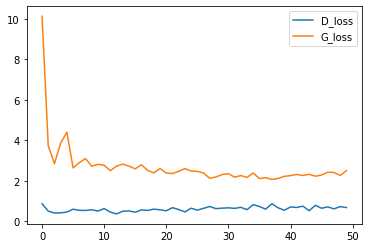

test_loss


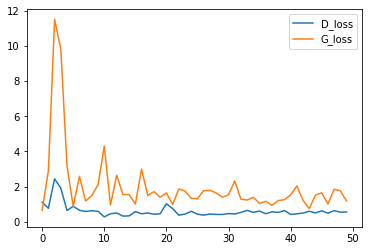

In [14]:
import pandas as pd
print('train_loss')
pd.DataFrame(gan._history[0]['train_loss_data']).plot()
plt.show()
print('test_loss')
pd.DataFrame(gan._history[0]['test_loss_data']).plot()
plt.show()

# Generated Images

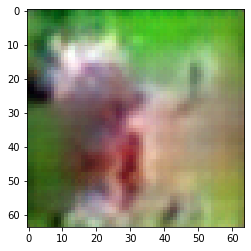

tensor([[[[0.2765]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [15]:
gan.eval()
gan.g.eval()
gan.d.eval()
generated = gan.sample(1)
btorch.vision.utils.pplot(btorch.vision.utils.img_MinMaxScaler(generated))
print(gan.d(generated))

# Discriminator on Real Image

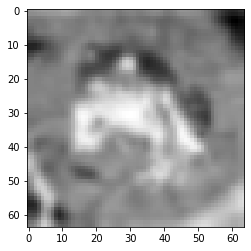

tensor([[[0.4779]]], device='cuda:0', grad_fn=<SelectBackward0>)


In [16]:
gan.eval()
gan.g.eval()
gan.d.eval()
for i in trainset:
  btorch.vision.utils.pplot(btorch.vision.utils.img_MinMaxScaler(i[0][0]))
  print(gan.d(i[0].unsqueeze(0).cuda())[0])
  break

# Evolution of Generator

epoch 0


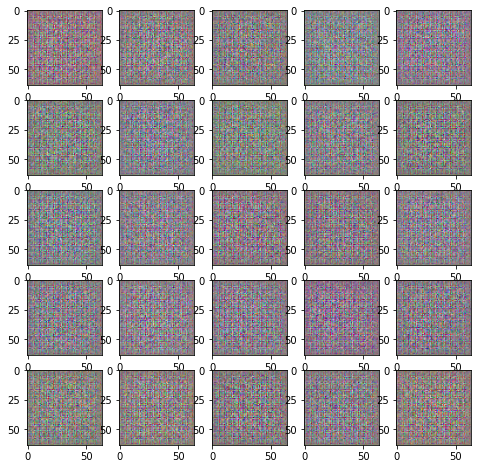

epoch 5


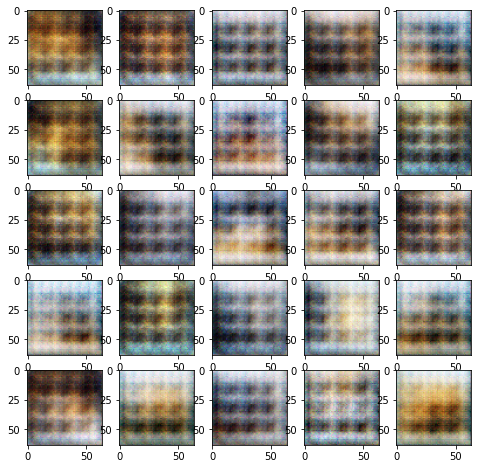

epoch 10


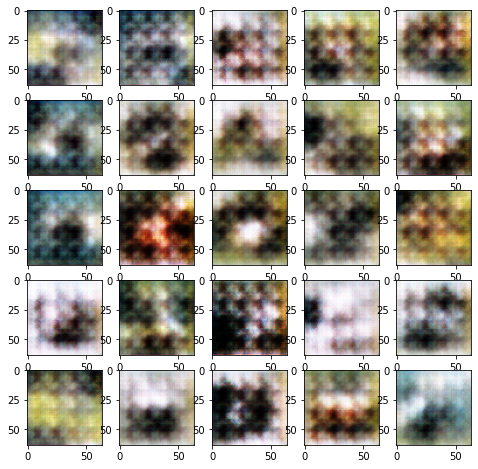

epoch 15


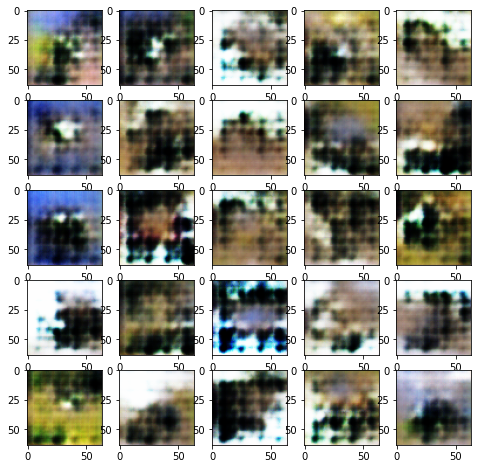

epoch 20


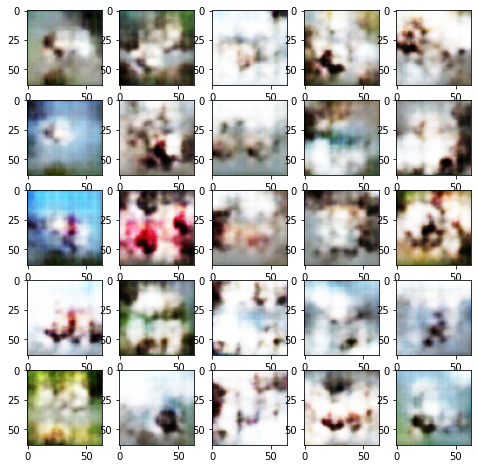

epoch 25


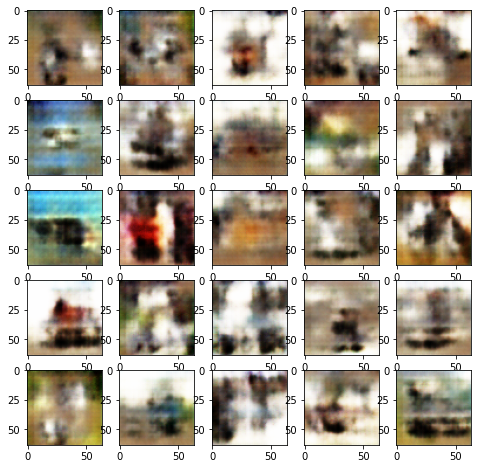

epoch 30


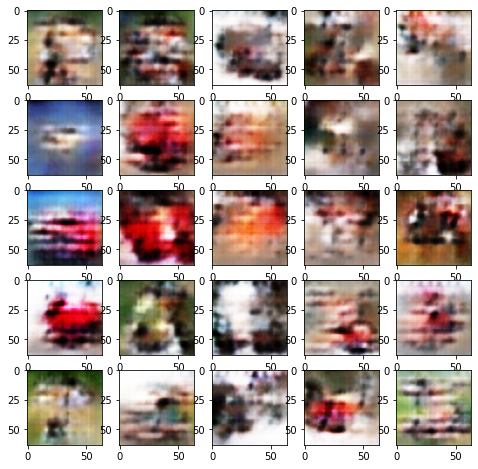

epoch 35


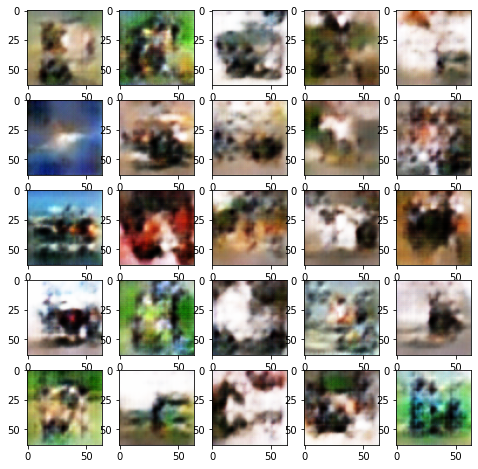

epoch 40


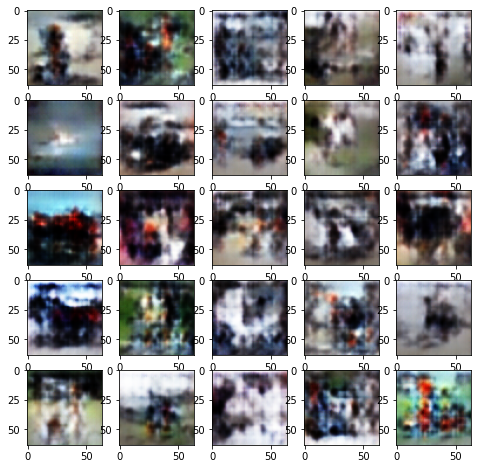

epoch 45


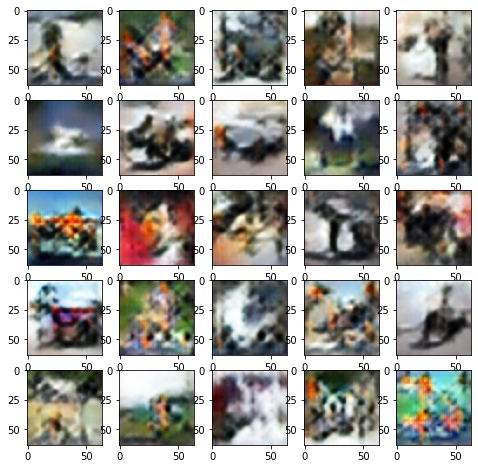

In [18]:
for i in range(0,len(gan._config['evol']), 5):
  print(f"epoch {i}")
  btorch.vision.utils.pplot(btorch.vision.utils.img_MinMaxScaler(gan._config['evol'][i]))